In [ ]:
!pip install einops

In [1]:
import torch 
from utils import setup_seed ,  count_parameters  , loading_data ,  ImageDataset
from modeling_mae import MAE 
from configuration import Config ,CifarConfig 
from  torch.utils.data import DataLoader 
from tqdm.auto import tqdm 
import time 
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Normalize




from datasets import load_dataset 
import torchvision

setup_seed(seed=42)

COMPILE = False 
EPOCHS = 120 
LR = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EVAL_INTERVAL  = 100
config = Config()

import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# Define the transform with resizing to 224x224
transform = Compose([
    Resize((224, 224)),  # Resizes images to 224x224
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize with mean and std for 3 channels (RGB)
])

# Load the CIFAR-10 dataset with resizing
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)





Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data 

In [ ]:
train_dataset = ImageDataset(train_data)
val_dataset = ImageDataset(test_data)

In [ ]:
64 * 2

In [2]:


train_loader=  DataLoader(
    train_dataset,
    batch_size =128, 
    shuffle=True,
    num_workers=4
)
test_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4
)



In [3]:
model = MAE(config)
print("Model Parameters:",count_parameters(model))




optimizer = torch.optim.AdamW(model.parameters(), lr=LR,weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

model.to(DEVICE)

Model Parameters: 5.15M


MAE(
  (encoder): Encoder(
    (patch): PatchEmbed(
      (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (encoder_blocks): ModuleList(
      (0-7): 8 x Block(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=256, out_features=256, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_feature

In [ ]:
criterion = torch.nn.MSELoss()


In [4]:
def patchify(imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = 16
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

def unpatchify(x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

mask torch.Size([1, 224, 224, 3])
im_masked torch.Size([1, 224, 224, 3])


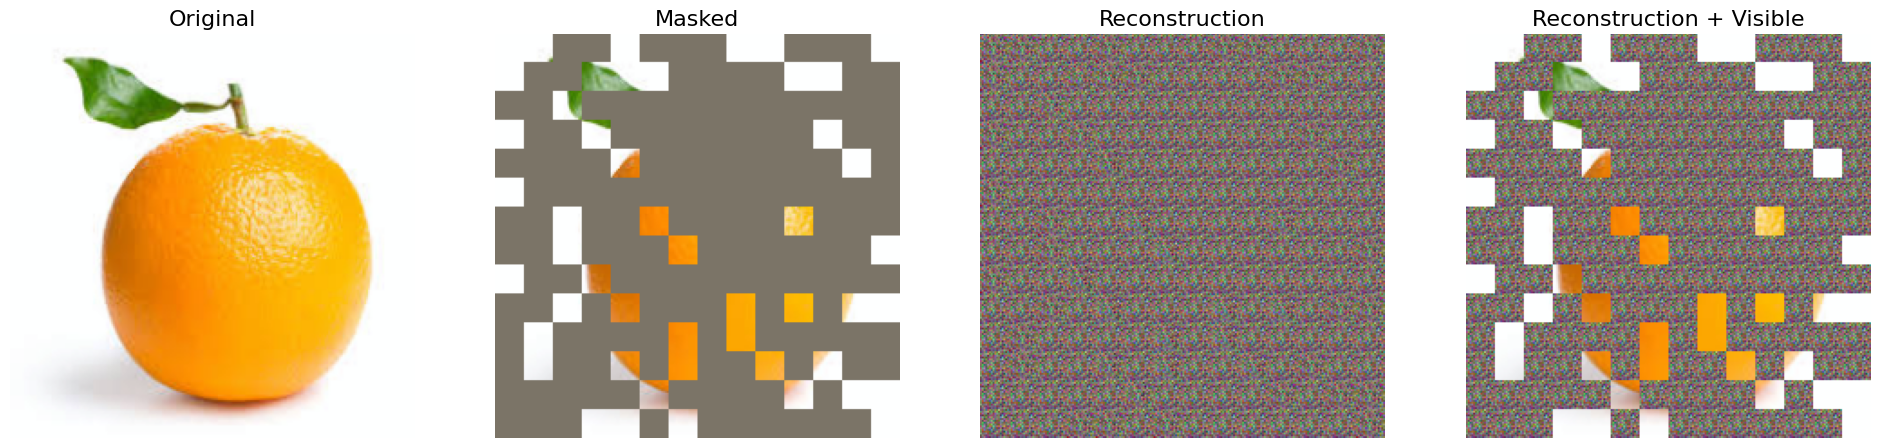

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models as models_mae, transforms

# ImageNet normalization constants
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def patchify(imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = 16
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

def unpatchify(x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs
        
def run_inference(image, model):
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the model's input size
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)  # Normalize
    ])

    model.to("cpu")
    image = image.convert('RGB')
    image = transform(image).unsqueeze(0).to("cpu")  # Add batch dimension

    # Run MAE
    with torch.no_grad():  # No need to track gradients for inference
        out, mask, ids_restore = model(image)
        
        # Post-process
        y = unpatchify(out)
        y = torch.einsum('nchw->nhwc', y).detach().cpu()

        mask = mask.detach()
        mask = mask.unsqueeze(-1).repeat(1, 1, 16**2 * 3)  # (N, H*W, p*p*3)
        mask = unpatchify(mask)  # 1 is removing, 0 is keeping
        mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
        x = torch.einsum('nchw->nhwc', image)

        # Masked image
        im_masked = x * (1 - mask)

        print("mask",mask.size())
        print("im_masked",im_masked.size())
        # MAE reconstruction pasted with visible patches
        im_paste = x * (1 - mask) + y * mask

        # Plot results
        plt.rcParams['figure.figsize'] = [24, 24]

        plt.subplot(1, 4, 1)
        show_image(x[0], "Original")

        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "Masked")

        plt.subplot(1, 4, 3)
        show_image(y[0], "Reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "Reconstruction + Visible")

        plt.show()

# Example usage
image_path = '/teamspace/studios/this_studio/orange.jpg'
from PIL import Image 
image = Image.open(image_path)
run_inference(image, model)



In [6]:
model.to(DEVICE)

MAE(
  (encoder): Encoder(
    (patch): PatchEmbed(
      (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (encoder_blocks): ModuleList(
      (0-7): 8 x Block(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=256, out_features=256, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_feature

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import time

# Hyperparameters
EPOCHS = 120
BATCH_SIZE = 32
LEARNING_RATE = 5e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EVAL_INTERVAL = 100
PATCH_SIZE = 16
IMAGE_SIZE = 224


# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
lr_func = lambda epoch: min((epoch + 1) / (200 + 1e-8), 0.5 * (math.cos(epoch / EPOCHS * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_func, verbose=True)


print("Starting to train")

# Initialize lists to store metrics
train_losses = []
val_losses = []
learning_rates = []
step_times = []
grad_norms = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_losses = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for step, (image, _) in progress_bar:
        start_time = time.time()
        image = image.to(DEVICE)
        optimizer.zero_grad()

        # Forward pass
        out, mask, _ = model(image)
        
        # Ensure model output and mask require gradients
        out.requires_grad_()
        mask.requires_grad_()

        # Post-process output
        y = unpatchify(out)
        y = torch.einsum('nchw->nhwc', y)

        # Post-process mask
        mask = mask.unsqueeze(-1).repeat(1, 1, 16**2 * 3)  # Adjust as needed
        mask = unpatchify(mask)
        mask = torch.einsum('nchw->nhwc', mask)

        # Original image in the same format
        x = torch.einsum('nchw->nhwc', image)

        # Ensure tensors for loss computation are on the same device and have requires_grad
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        mask = mask.to(DEVICE)

        # Masked image
        im_masked = x * (1 - mask)
        

        # Compute the loss
        loss = torch.mean((y - x) ** 2 * mask) / 0.75

        # Backward pass and gradient clipping
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Track training metrics
        epoch_train_losses.append(loss.item())
        grad_norms.append(grad_norm)
        step_times.append((time.time() - start_time) * 1000)  # Step time in milliseconds
        learning_rates.append(scheduler.get_last_lr()[0])

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'grad_norm': f"{grad_norm:.4f}",
            'step_time': f"{step_times[-1]:.4f}ms",
            'lr': f"{learning_rates[-1]:.6f}"
        })

        # Validation phase at specified intervals
        if (step + 1) % EVAL_INTERVAL == 0:
            model.eval()
            with torch.no_grad():
                val_losses_epoch = []
                for val_image, _ in test_loader:
                    val_image = val_image.to(DEVICE)
                    val_out, val_mask, _ = model(val_image)
                    val_y = unpatchify(val_out)
                    val_y = torch.einsum('nchw->nhwc', val_y)

                    val_mask = val_mask.unsqueeze(-1).repeat(1, 1, 16**2 * 3)
                    val_mask = unpatchify(val_mask)
                    val_mask = torch.einsum('nchw->nhwc', val_mask)

                    val_x = torch.einsum('nchw->nhwc', val_image)

                    val_im_masked = val_x * (1 - val_mask)

                    try:
                        val_loss = torch.mean((val_y - val_x) ** 2 * val_mask) / 0.75
                        val_losses_epoch.append(val_loss.item())
                    except RuntimeError as e:
                        print(f"Error computing validation loss: {e}")
                        break

                avg_val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
                val_losses.append(avg_val_loss)
                print(f'Validation loss: {avg_val_loss:.4f}')

            model.train()

    # Compute average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)
    
    # Step the learning rate scheduler
    lr_scheduler.step()

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{EPOCHS} - Train loss: {avg_train_loss:.4f}, Val loss: {val_losses[-1]:.4f}")

    # Visualize results after each epoch
    if (epoch + 1) % 20 == 0:
        print(f"Visualizing images after Epoch {epoch + 1}")
        model.eval()
        image_path = '/teamspace/studios/this_studio/orange.jpg'
        img = Image.open(image_path)
        run_inference(img, model)



Starting to train


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/120:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/120:  26%|██▌       | 101/391 [00:25<07:53,  1.63s/it, loss=0.2510, grad_norm=1.5565, step_time=164.7561ms, lr=0.000010]

Validation loss: 0.2681


Epoch 1/120:  51%|█████▏    | 201/391 [00:50<05:05,  1.61s/it, loss=0.2178, grad_norm=1.6822, step_time=164.7921ms, lr=0.000010]

Validation loss: 0.2176


Epoch 1/120:  77%|███████▋  | 301/391 [01:15<02:23,  1.60s/it, loss=0.2033, grad_norm=1.9226, step_time=163.8072ms, lr=0.000010]

Validation loss: 0.1974


Epoch 1/120: 100%|██████████| 391/391 [01:32<00:00,  4.24it/s, loss=0.2083, grad_norm=1.5071, step_time=105.7618ms, lr=0.000010]

Epoch 1/120 - Train loss: 0.2475, Val loss: 0.1974



Epoch 2/120:  26%|██▌       | 101/391 [00:25<07:47,  1.61s/it, loss=0.1834, grad_norm=1.2671, step_time=164.7165ms, lr=0.000010]

Validation loss: 0.1805


Epoch 2/120:  51%|█████▏    | 201/391 [00:50<04:59,  1.58s/it, loss=0.1816, grad_norm=1.1107, step_time=164.4323ms, lr=0.000010]

Validation loss: 0.1772


Epoch 2/120:  77%|███████▋  | 301/391 [01:15<02:24,  1.60s/it, loss=0.1671, grad_norm=1.0824, step_time=166.5523ms, lr=0.000010]

Validation loss: 0.1754


Epoch 2/120: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s, loss=0.1739, grad_norm=1.3874, step_time=103.8921ms, lr=0.000010]

Epoch 2/120 - Train loss: 0.1787, Val loss: 0.1754



Epoch 3/120:  25%|██▌       | 99/391 [00:18<00:53,  5.42it/s, loss=0.1771, grad_norm=0.8821, step_time=165.3314ms, lr=0.000010]

In [ ]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

print("Training complete")

In [ ]:
import torch

# Define paths
model_path = 'new_model_2.pth'
optimizer_path = 'optimizer.pth'
scheduler_path = 'scheduler.pth'

# Save model, optimizer, and scheduler
def save_checkpoint(model, optimizer, scheduler, model_path, optimizer_path, scheduler_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, model_path)

# Example usage
save_checkpoint(model, optimizer, scheduler, model_path, optimizer_path, scheduler_path)


In [ ]:
import torch

# Define paths
model_path = '/teamspace/studios/this_studio/new_model_2.pth'

# Load model, optimizer, and scheduler
def load_checkpoint(model, optimizer, scheduler, model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
   
    return model

model  = load_checkpoint(model, optimizer, scheduler, model_path)
model.eval()

In [ ]:
model.to("cuda")

In [ ]:
image = train_data[2]

In [ ]:
img = image['image']

In [ ]:
from PIL import Image 

img = Image.open("/teamspace/studios/this_studio/orange.jpg")

In [ ]:
img = img.resize((32,32))

In [ ]:
img

In [ ]:
img, label = train_dataset[0]

In [ ]:
label

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation to preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 32x32
    transforms.ToTensor(),        # Convert the image to a tensor
])

# Load and preprocess the image
image_path = '/teamspace/studios/this_studio/orange.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(DEVICE)  # Move to the appropriate device

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    out, mask, ids_restore = model(image)

# Reshape the mask to match the spatial dimensions of the image
patch_size = 4
num_patches_per_dim = 32 // patch_size  # 8 patches per dimension

# Reshape the mask to [1, 8, 8] and then expand to [1, 1, 32, 32]
mask_reshaped = mask.view(1, num_patches_per_dim, num_patches_per_dim)
mask_upsampled = mask_reshaped.unsqueeze(1).repeat(1, 3, patch_size, patch_size)

# Apply the mask to the original image
masked_image = image * (1 - mask_upsampled)

# Apply the mask to the original image
masked_image = image * (1 - mask_upsampled)

out_reshaped = out.view(1, 3, 32, 32)
# Concatenate the original, masked, and reconstructed images
img = torch.cat([masked_image, out_reshaped, image], dim=0)

# Convert tensors to numpy arrays for visualization
def tensor_to_image(tensor):
    return tensor.squeeze().permute(1, 2, 0).cpu().numpy()

original_image_np = tensor_to_image(image)
masked_image_np = tensor_to_image(masked_image)
reconstructed_image_np = tensor_to_image(out_reshaped)

# Plot the images
plt.figure(figsize=(12, 4))

# Masked Image
plt.subplot(1, 3, 1)
plt.imshow(masked_image_np)
plt.title('Masked Image')
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image_np)
plt.title('Reconstructed Image')
plt.axis('off')

# Original Image
plt.subplot(1, 3, 3)
plt.imshow(original_image_np)
plt.title('Original Image')
plt.axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [ ]:
masked_image torch.Size([1, 3, 32, 32])
out torch.Size([1, 64, 48])
image torch.Size([1, 3, 32, 32])
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
Cell In[82], line 42
     40 print("image",image.size())
     41 # Concatenate the original, masked, and reconstructed images
---> 42 img = torch.cat([masked_image, out, image], dim=0)
     44 # Convert tensors to numpy arrays for visualization
     45 def tensor_to_image(tensor):

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the transformation to preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the image to 32x32
    transforms.ToTensor(),        # Convert the image to a tensor
])

# Load and preprocess the image
image_path = '/teamspace/studios/this_studio/orange.jpg'  # Replace with your image path
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(DEVICE)  # Move to the appropriate device

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    out, mask, ids_restore = model(image)

# Assuming patch_size is 4 (as per your earlier code)
patch_size = 4
num_patches_per_dim = 32 // patch_size  # 32x32 image with 4x4 patches

# Reshape the output to reconstruct the image
batch_size, num_patches, patch_dim = out.shape
channels = 3  # Assuming RGB images
reconstructed_image = out.view(batch_size, num_patches_per_dim, num_patches_per_dim, channels, patch_size, patch_size)
reconstructed_image = reconstructed_image.permute(0, 3, 1, 4, 2, 5).contiguous()
reconstructed_image = reconstructed_image.view(batch_size, channels, 32, 32)

# Reshape the mask to match the patch layout
mask_np = mask.view(num_patches_per_dim, num_patches_per_dim).cpu().numpy()

# Function to visualize the image and mask
def visualize_masking(original_image, mask, reconstructed_image):
    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.squeeze().permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy()

    # Plot the images
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_np)
    plt.title('Original Image')
    plt.axis('off')

    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed_image_np)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

# Visualize the results
visualize_masking(image, mask_np, reconstructed_image)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np


# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = transform(img)
img = img.unsqueeze(0).to(DEVICE)

# Get the output and mask from the model
out, mask, _ = model(img)

# Reshape the mask to match the image dimensions
patch_size = 4
num_patches = (32 // patch_size) ** 2
mask = mask.view(1, num_patches, 1)
mask = mask.permute(0, 2, 1).contiguous()
mask = mask.view(1, 1, 8, 8)

# Upsample the mask to match the image dimensions
mask = torch.nn.functional.interpolate(mask, size=(32, 32), mode='nearest')

# Convert the mask to a numpy array
mask = mask.cpu().numpy().squeeze()

# Plot the original image and the masked image
img = img.cpu().numpy().squeeze().transpose(1, 2, 0)
img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img * mask[:, :, np.newaxis])
plt.title('Masked Image')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load the trained model
model.eval()

# Load the image
img_path = '/teamspace/studios/this_studio/orange.jpg'
img = Image.open(img_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = transform(img)
img = img.unsqueeze(0).to(DEVICE)

# Get the output and mask from the model
out, mask, _ = model(img)

# Reshape the output to match the image dimensions
patch_size = 4
num_patches = (32 // patch_size) ** 2
out = out.view(1, num_patches, -1)

# Convert the output to a numpy array
out = out.cpu().detach().numpy().squeeze().transpose(1, 0)
out = out.reshape(8, 8, 3)

# Upsample the output to match the image dimensions
out = np.repeat(out, patch_size, axis=0)
out = np.repeat(out, patch_size, axis=1)

# Convert the mask to a numpy array
mask = mask.cpu().numpy().squeeze()

# Plot the original image, the masked image, and the predicted image
img = img.cpu().numpy().squeeze().transpose(1, 2, 0)
img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(img * mask[:, :, np.newaxis])
plt.title('Masked Image')

plt.subplot(1, 3, 3)
plt.imshow(out.clip(0, 1))
plt.title('Predicted Image')

plt.show()

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model
model.eval()
# Preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean and std for each of the 3 channels
])

img = transform(img)
img = img.unsqueeze(0).to(DEVICE)

# Perform inference
with torch.no_grad():
    out, mask , ids_restore = model(img)

# Reshape the output to match the patch structure
patch_size = 4  # 224 / 14 = 16
num_patches = (32 // patch_size) ** 2  # 14 * 14 = 196
image_patches = img.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
image_patches = image_patches.permute(0, 2, 3, 1, 4, 5).contiguous()
image_patches = image_patches.view(img.size(0), num_patches, -1)  # [1, 196, 768]

# Mask the image patches
masked_img = image_patches * mask.unsqueeze(-1)

print("Shape of masked_img before decoder:", masked_img.shape)  # Debugging shape of input
print("Shape of ids_restore:", ids_restore.shape)  # Check ids_restore shape

# Use the decoder to predict the original image
predicted_img = model.decoder(masked_img, ids_restore)

# Reshape the predicted image to match the original image shape
predicted_img = predicted_img.view(1, 14, 14, 3, 16, 16)
predicted_img = predicted_img.permute(0, 3, 1, 4, 2, 5).contiguous()
predicted_img = predicted_img.view(1, 3, 224, 224)

# Convert the predicted image to a numpy array
predicted_img = predicted_img.squeeze(0).cpu().numpy()
predicted_img = np.transpose(predicted_img, (1, 2, 0))
predicted_img = predicted_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

# Display the original, masked, and predicted images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.transpose(img.squeeze(0).cpu().numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
plt.title('Original Image')
plt.subplot(1, 3, 2)
masked_img = masked_img.view(1, 14, 14, 3, 16, 16)
masked_img = masked_img.permute(0, 3, 1, 4, 2, 5).contiguous()
masked_img = masked_img.view(1, 3, 224, 224)
masked_img = masked_img.squeeze(0).cpu().numpy()
masked_img = np.transpose(masked_img, (1, 2, 0))
masked_img = masked_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
plt.imshow(masked_img)
plt.title('Masked Image')
plt.subplot(1, 3, 3)
plt.imshow(predicted_img)
plt.title('Predicted Image')
plt.show()



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def run_one_image(img, model, device):
    model.eval()
    
    # Preprocess the image
    x = torch.tensor(img).float().to(device)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # Run the model
    with torch.no_grad():
        out, mask = model(x)

    # Reshape the output
    patch_size = 16
    num_patches = (224 // patch_size) ** 2
    out = out.view(1, 14, 14, 3, patch_size, patch_size)
    out = out.permute(0, 3, 1, 4, 2, 5).contiguous()
    out = out.view(1, 3, 224, 224)

    # Reshape the mask
    mask = mask.view(1, 14, 14, 1).repeat(1, 1, 1, patch_size**2 * 3)
    mask = mask.view(1, 3, 224, 224)

    # Convert tensors back to image format
    x = torch.einsum('nchw->nhwc', x)
    out = torch.einsum('nchw->nhwc', out)
    mask = torch.einsum('nchw->nhwc', mask)

    # Create masked and reconstructed images
    im_masked = x * (1 - mask)
    im_paste = x * (1 - mask) + out * mask

    # Visualize
    plt.figure(figsize=(24, 6))

    plt.subplot(1, 4, 1)
    show_image(x[0].cpu(), "Original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0].cpu(), "Masked")

    plt.subplot(1, 4, 3)
    show_image(out[0].cpu(), "Reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0].cpu(), "Reconstruction + Visible")

    plt.show()


model = model.to(DEVICE)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


img = transform(img).permute(1, 2, 0).numpy()

# Run the visualization
run_one_image(img, model, DEVICE)

In [ ]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


In [ ]:
def unpatchify(x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

In [ ]:
model.to("cuda")